Stock data from https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Basic setup: Read in the file and add the all time high to the dataframe.

In [2]:
sp500 = pd.read_csv("sp500.csv")
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500['ath'] = sp500['Close'].cummax()
sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ath
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000,16.66
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000,16.85
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000,16.93
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000,16.98
4,1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000,17.08


Compute the all time high fraction.

In [16]:
sp500['ath_frac'] = sp500['Close'] / sp500['ath']
sp500.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ath,ath_frac
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000,16.66,1.0
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000,16.85,1.0
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000,16.93,1.0
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000,16.98,1.0
4,1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000,17.08,1.0


Now compute two interesting monthly aggregates:
1. The monthly all time high.
2. The lowest the market has dropped since previous all time (as of that date). We call this the `ath_frac`.

In [8]:
monthly_ath = sp500.groupby(pd.Grouper(key ='Date', freq="M"))['ath'].max()
monthly_ath.index = monthly_ath.index.to_period("M")
monthly_ath.to_frame().head()

,ath
Date,
1950-01,17.090000
1950-02,17.320000
1950-03,17.559999
1950-04,18.049999
1950-05,18.780001


In [9]:
monthly_low_ath_frac = sp500.groupby(pd.Grouper(key ='Date', freq="M"))['ath_frac'].min()
monthly_low_ath_frac.index = monthly_low_ath_frac.index.to_period("M")
monthly_low_ath_frac.to_frame().head()

,ath_frac
Date,
1950-01,0.975424
1950-02,0.980947
1950-03,0.984624
1950-04,0.983934
1950-05,0.991790


In [10]:
sp500_monthly = monthly_ath.to_frame()
sp500_monthly['ath_frac_low'] = monthly_low_ath_frac
sp500_monthly = sp500_monthly.rename(columns={'ath': 'ath_max'})
sp500_monthly.head()

,ath_max,ath_frac_low
Date,,
1950-01,17.090000,0.975424
1950-02,17.320000,0.980947
1950-03,17.559999,0.984624
1950-04,18.049999,0.983934
1950-05,18.780001,0.991790


Define a useful plotting function.

In [17]:
#taken more or less verbatim from https://matplotlib.org/gallery/text_labels_and_annotations/date.html
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

font = {'size'   : 22}

plt.rc('font', **font)

def pretty_date_plot(df, cname, log=False):
    #These three magic lines of code are importnat
    #First, we convert the index into a datetime object. Currently assumed to be a pandas Period object.
    #Then we convert into a records object
    df = df.copy()
    df.index = df.index.to_timestamp()
    r = df[[cname]].to_records()    

    years = mdates.YearLocator(5)   # every 5 years
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots(figsize=(18, 16))
    if log:
        ax.semilogy(r.Date, getattr(r, cname)) 
    else:
        ax.plot(r.Date, getattr(r, cname)) 

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years...
    datemin = np.datetime64(r.Date[0], 'Y')
    datemax = np.datetime64(r.Date[-1], 'Y') + np.timedelta64(1, 'Y')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    def price(x):
        return '$%1.2f' % x
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = price
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()    
    return ax

Make a few plots.

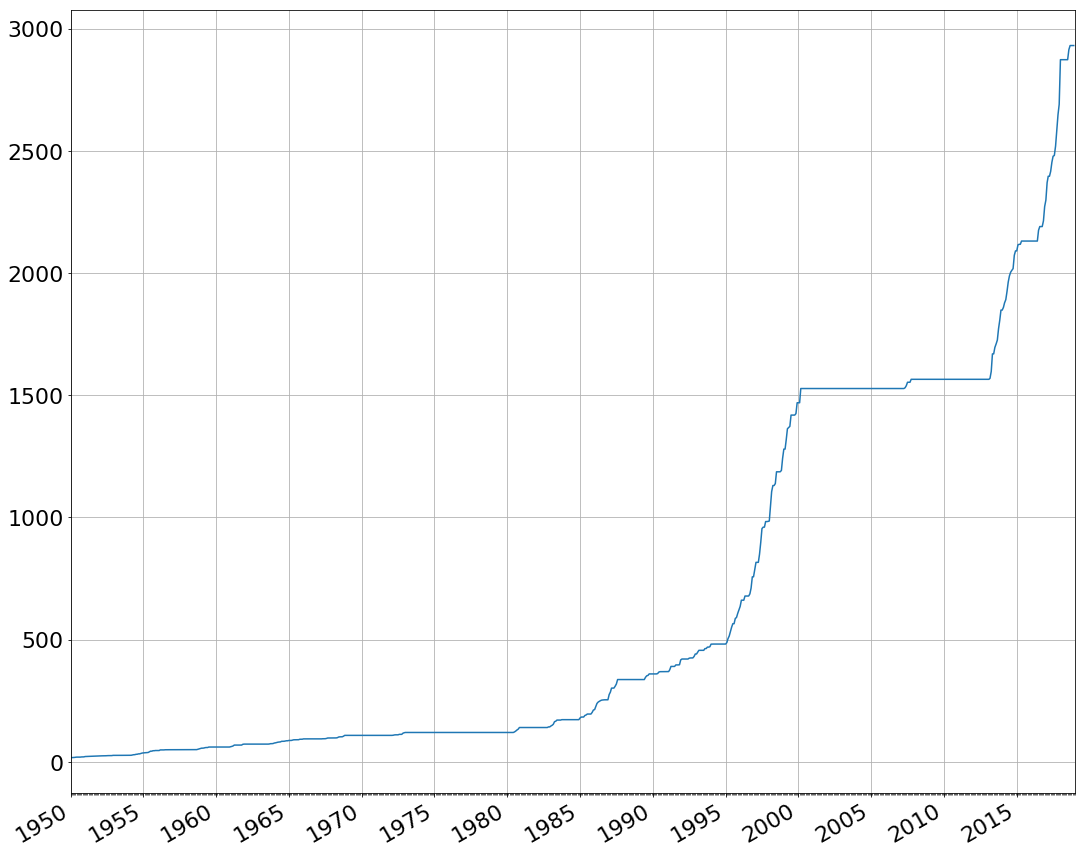

In [12]:
ax = pretty_date_plot(sp500_monthly, 'ath_max', log=False)

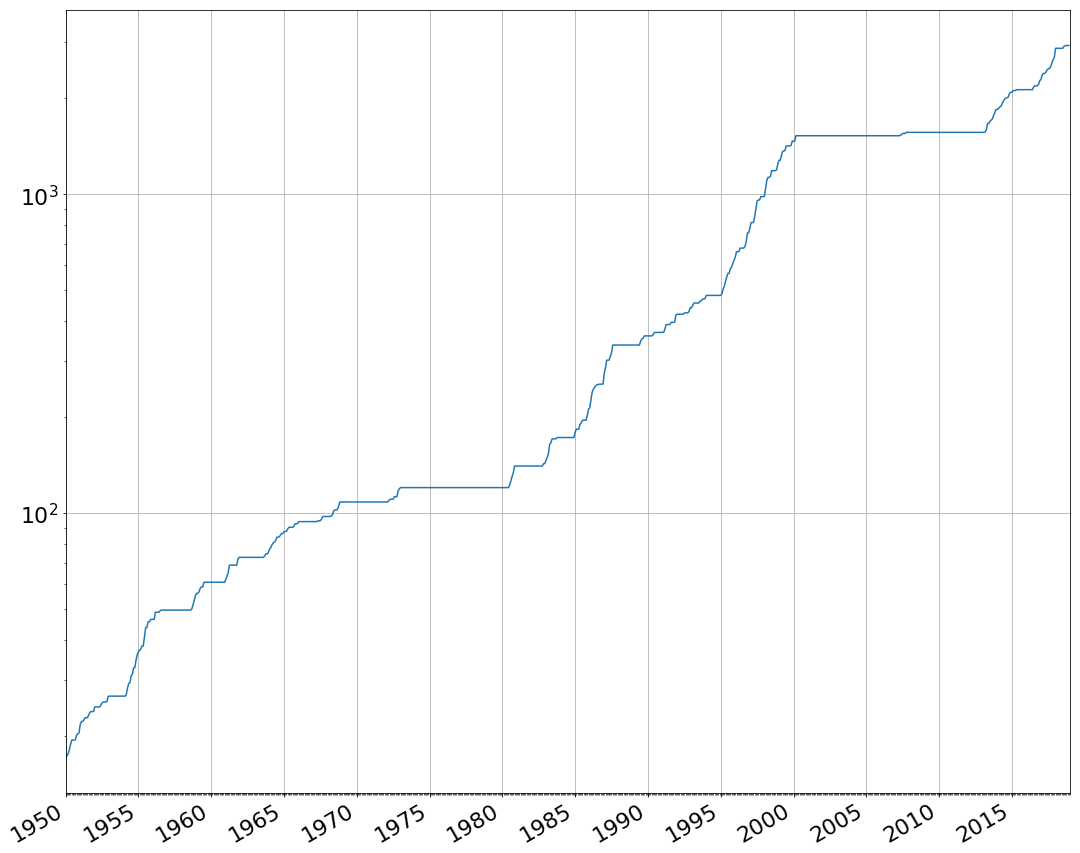

In [14]:
ax = pretty_date_plot(sp500_monthly, 'ath_max', log=True)

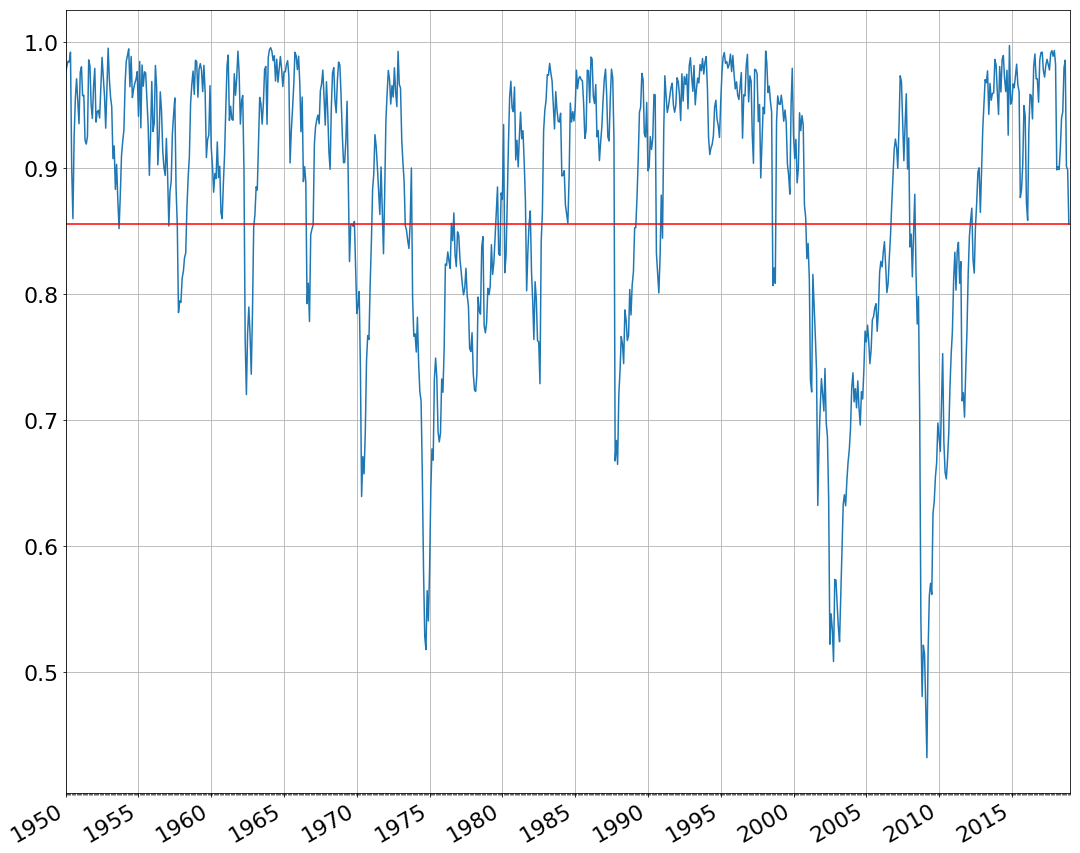

In [22]:
ax = pretty_date_plot(sp500_monthly, 'ath_frac_low')
ax.axhline(y=sp500_monthly.iloc[-1, :]['ath_frac_low'], color='r', linestyle='-')